In [9]:
import pandas as pd                  # for tabular data handling
from pathlib import Path             # for handling filesystem paths

data = pd.read_csv("./DKTatlas_ThickAvg.csv")
#data

train_data = data[data['p_factor'].notna()]
test_data  = data[data['p_factor'].isna()]

Minimum p_factor: -1.608374501
Number of subjects with min value: 177


<Axes: >

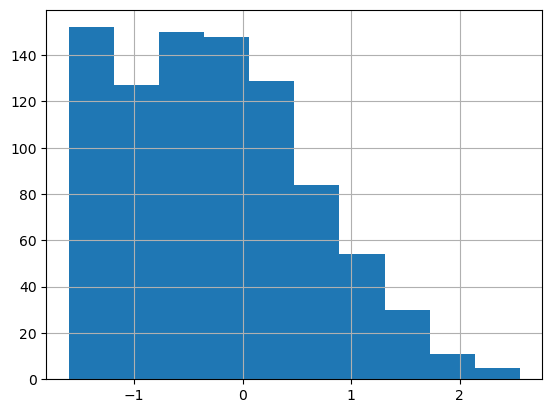

In [12]:
# ---------------------------------------------------------------------------
# Remove subjects at the minimum p_factor value and plot distributions
# ---------------------------------------------------------------------------

# Plot histogram of p_factor for all training subjects
#train_data["p_factor"].hist(bins=100)

# Print minimum value and its count
print("Minimum p_factor:", train_data["p_factor"].min())
print("Number of subjects with min value:",
      train_data["p_factor"].value_counts()[train_data["p_factor"].min()])

# Remove subjects with minimum p_factor (to avoid bias in modeling)
min_val_idx = train_data["p_factor"] == train_data["p_factor"].min()
removed_train_data = train_data[min_val_idx].copy()
clean_train_data   = train_data[~min_val_idx]

# Plot histogram after cleaning
clean_train_data["p_factor"].hist()